In [1]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf

import model_explain.plot as meplot
import model_explain.shap as meshap

from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

## Load Data and Generate Sample Data (Due to memory limitation)

In [183]:
raw_data = pd.read_csv(os.path.join(root_path, "sentiment140_twitter.csv"), names=['target', 'id', 'date', 'flag', 'user', 'text'], header=None)
data = raw_data[raw_data.text.isnull()==False].drop_duplicates().reset_index(drop=True)
data['hashtag'] = data['text'].apply(lambda x: textClean.get_hashtag(x))
data['atuser'] = data['text'].apply(lambda x: re.findall(r"@(\w+)", x))
data['clean_tweet'] = data['text'].apply(lambda x: textClean.remove_string_startwith(x, '@'))
data['clean_tweet'] = data['clean_tweet'].apply(lambda x: textClean.remove_string_startwith(x, '#'))
data['clean_tweet'] = data['clean_tweet'].apply(lambda x: textClean.remove_string_startwith(x, 'http'))
data['label'] = np.where(data['target']==0, 0, 1)

In [184]:
data.head(3)

target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   

              user                                               text hashtag  \
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...      []   
1    scotthamilton  is upset that he can't update his Facebook by ...      []   
2         mattycus  @Kenichan I dived many times for the ball. Man...      []   

         atuser                                   clean_tweet_join  label  
0  [switchfoot]    - Awww, that's a bummer.  You shoulda got Da...      0  
1            []  is upset that he can't update his Facebook by ...      0  
2    [Kenichan]   I dived many times for the ball. Managed to s...      0

In [188]:
i = 175
print(data.text[i])
print("-----------")
# print(data.clean_tweet[i])
print("-----------")
print(data.clean_tweet[i])

@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail
-----------
-----------
 I'm so sorry you're having to go through this. Again.  


## Explore Data
We run Explore Data in sample dataset.

In [159]:
import random
sample_size = 100000
sample_data = pd.concat([data.loc[data['hashtag'] != '[]'], data.loc[data['hashtag'] == '[]'].sample((sample_size - len(data_with_hashtag)), random_state = 3)]).reset_index(drop = True)
pos_tweet = list(x.split() for x in sample_data[sample_data['label']==1]['clean_tweet'])
neg_tweet = list(x.split() for x in sample_data[sample_data['label']==0]['clean_tweet'])
postop10tfidf = tfidf.get_top_n_tfidf_bow(pos_tweet, top_n_tokens = 30)
negtop10tfidf = tfidf.get_top_n_tfidf_bow(neg_tweet, top_n_tokens = 30)
print('top 30 negative review tfidf', negtop10tfidf)
print('top 30 positive review tfidf', postop10tfidf)

top 30 negative review tfidf ['4', 'Very', 'ich', 'really?', "i'm", 'i', 'What?', 'reboot', '#myweakness', "What's", 'confused', 'revising', 'VERY', '#onroad', 'rlly', 'V', 'hurts.', 'hurts', 'confused.', 'hungry!', 'Ugh,', 'Ugh', 'says', '#jtv', 'really', 'im', 'heartbroken', 'cold', 'Yes', 'interview']
top 30 positive review tfidf ['!', "THAT'S", 'RED', 'Retweet', 'Search', 'See', 'Sleep', 'So...', 'Straight', 'Sure', 'Sweet', 'Sweet!', 'THANK', 'THANKS', 'THANKS!', 'Testing', 'Post', 'Thank', 'Thanks', 'Thanks!', 'Thanks!!', 'Thanks,', 'Thanks.', 'The', "They're", 'Thinking', 'Thx', 'Tony', 'Try', 'Twitter']


In [160]:
top10_posfreq_list = DataExploration.get_topn_freq_bow(pos_tweet, topn = 10)
top10_negfreq_list = DataExploration.get_topn_freq_bow(neg_tweet, topn = 10)
print(top10_posfreq_list)
print(top10_negfreq_list)

[('the', 17628), ('to', 15956), ('I', 12103), ('a', 11983), ('for', 9492), ('you', 9030), ('and', 8689), ('is', 6774), ('my', 6656), ('in', 6253)]
[('to', 18431), ('I', 17882), ('the', 15655), ('a', 10621), ('my', 9508), ('and', 8212), ('i', 8004), ('is', 7371), ('in', 6851), ('for', 6391)]


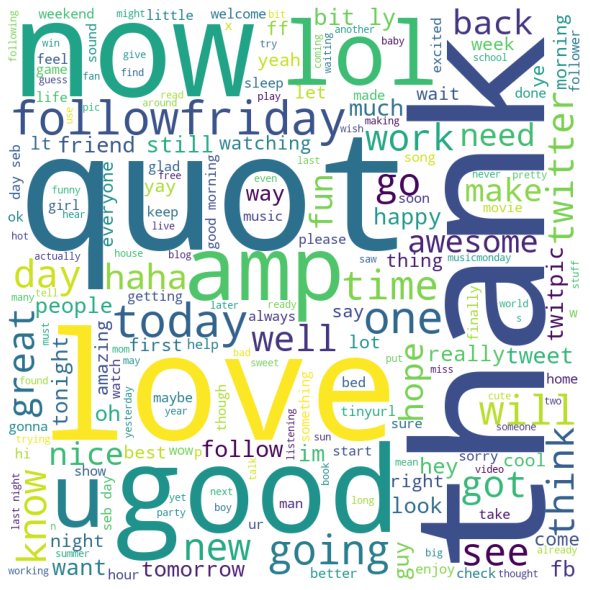

In [161]:
DataExploration.generate_word_cloud(pos_tweet)

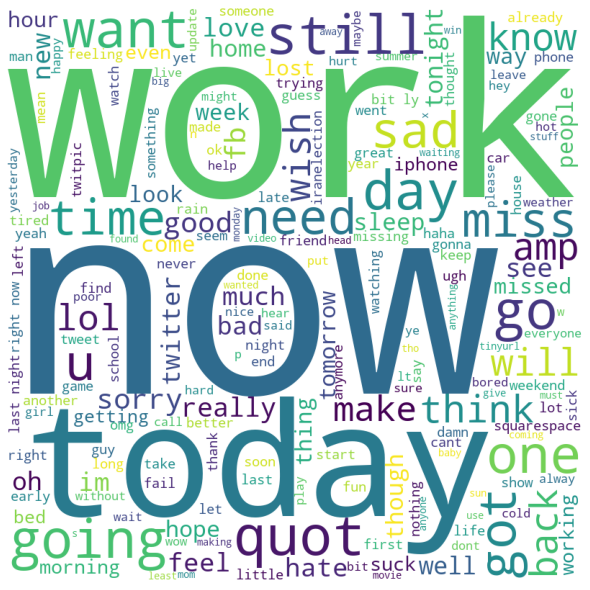

In [162]:
DataExploration.generate_word_cloud(neg_tweet)

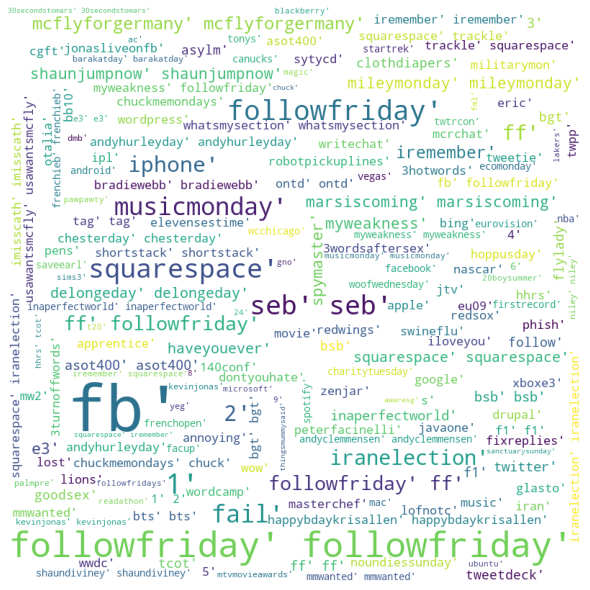

In [163]:
hashtag_list = [sample_data.hashtag]
DataExploration.generate_word_cloud(hashtag_list)

We didn't remove stop words, so the LDA does not work well, to do topic modelling, we need to remove stop words. But for sentiment analysis, it is better to keep all words.
However, even for sentiment analysis, we need to set minimal words length, there we need to set it as 2.

In [164]:
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(pos_tweet, num_topics = no_topics)
lda.lda_topics(lda_allbow)

Topics var1  var2    var3 var4    var5 var6   var7  var8  var9  var10
0       1  you  your     the  for       I   of      a   and  have  Thank
1       2    i    to      my  and       a  the   just    in    is     it
2       3    a     -      my   in      of  the    and  like    is   from
3       4    I   the       a   of       i   it   that   was    to    for
4       5   to     I     the  and       a   in  going  some   off     go
5       6   to   and     you  the      on    I      i    me     u     my
6       7  the    is    with    I     and   in   this    on    my      a
7       8  you     a      to  the     are    i     on    of    in     is
8       9  for   the  thanks   my  Thanks    a     to   all   and     is
9      10   to   and      my  for     the    a    I'm     I    in     me

## Prepare training/testing/validation dataset

In [165]:
X = [x for x in data.clean_tweet]
y = np.array(data.label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state = 11)

## Word Embedding & RNN

### Glove Word Embedding

In [89]:
# load the whole embedding into memory
embeddings_index = dict()
embedding_dim = 100 
# download glove word embedding first and then load it with the following code
f = open('C:/ProgramData/Anaconda3/append_file/glove/glove.6B.100d.txt', encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close
print('loaded %s word vectors.' % len(embeddings_index))

loaded 400000 word vectors.


In [166]:
max_length = int(np.percentile(data.clean_tweet.apply(lambda x: len(x.split())), 95))

t = Tokenizer()
t.fit_on_texts(X_train)
# print("words with freq:", t.word_docs)

vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(X_train)
print('Encoding:\n', encoded_docs[0])
print('\nText:\n', list(X_train)[0])
print('\nWord Indices:\n', [(t.index_word[i], i) for i in encoded_docs[0]])
print('vocab size:', vocab_size)
train_padded_docs = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')


Encoding:
 [25230, 368, 242, 25231, 46, 13, 2, 2263, 10322, 664]

Text:
 #civicsummit welcome www.thetylerallen.com on the content creation team 

Word Indices:
 [('civicsummit', 25230), ('welcome', 368), ('www', 242), ('thetylerallen', 25231), ('com', 46), ('on', 13), ('the', 2), ('content', 2263), ('creation', 10322), ('team', 664)]
vocab size: 85094


In [167]:
# Initialize a matrix with zeros having dimensions equivalent to vocab size and 100
embedding_matrix = zeros((vocab_size, embedding_dim))
for word, idx_word in t.word_index.items():
    word_vector = embeddings_index.get(word)
    if word_vector is not None:
        embedding_matrix[idx_word] = word_vector
print('word:', t.index_word[1])
print('Embedding:\n', embedding_matrix[1])
print('length of embedding matrix is:', len(embedding_matrix))
print('vocabulary size is %s.' % vocab_size)

word: i
Embedding:
 [-0.046539    0.61966002  0.56647003 -0.46584001 -1.18900001  0.44599
  0.066035    0.31909999  0.14679    -0.22119001  0.79238999  0.29905
  0.16073     0.025324    0.18678001 -0.31000999 -0.28108001  0.60514998
 -1.0654      0.52476001  0.064152    1.03579998 -0.40779001 -0.38011
  0.30801001  0.59964001 -0.26991001 -0.76034999  0.94221997 -0.46919
 -0.18278     0.90652001  0.79671001  0.24824999  0.25713     0.6232
 -0.44768     0.65357     0.76902002 -0.51229    -0.44332999 -0.21867
  0.38370001 -1.14830005 -0.94397998 -0.15062     0.30012    -0.57805997
  0.20175    -1.65910006 -0.079195    0.026423    0.22051001  0.99713999
 -0.57538998 -2.72659993  0.31448001  0.70521998  1.43809998  0.99125999
  0.13976     1.34739995 -1.1753      0.0039503   1.02980006  0.064637
  0.90886998  0.82871997 -0.47003001 -0.10575     0.5916     -0.42210001
  0.57331002 -0.54114002  0.10768     0.39783999 -0.048744    0.064596
 -0.61436999 -0.28600001  0.50669998 -0.49757999 -0.81

In [93]:
from scipy.spatial import distance
def find_closest_embeddings(embedding):
    return sorted(embeddings_index.keys(), key = lambda word: distance.euclidean(embeddings_index[word], embedding))
find_closest_embeddings((embedding_matrix[t.word_index['welcome']]))

['welcome',
 'welcoming',
 'welcomed',
 'wish',
 'occasion',
 'inviting',
 'hoped',
 'eager',
 'hoping',
 'opportunity',
 'hope',
 'surprise',
 'invitation',
 'embrace',
 'greet',
 'happy',
 'greeted',
 'promise',
 'come',
 'calling',
 'thank',
 'wishes',
 'praise',
 'invite',
 'delighted',
 'assured',
 'arrival',
 'ready',
 'encouragement',
 'wishing',
 'wished',
 'expect',
 'gesture',
 'call',
 'sort',
 'welcomes',
 'coming',
 'offered',
 'give',
 'pleased',
 '404-222-8268',
 'promised',
 'encouraged',
 'return',
 'urge',
 'wanting',
 'invited',
 'sign',
 'promises',
 'cheer',
 'indeed',
 'thanks',
 'leave',
 'grateful',
 'reminded',
 'enthusiastic',
 'bring',
 'urging',
 'noting',
 'given',
 'supportive',
 'nonetheless',
 'prepared',
 'reception',
 'nod',
 'immediate',
 'moment',
 'celebrate',
 'surely',
 'accept',
 'acceptance',
 'farewell',
 'waiting',
 'delight',
 'hopeful',
 'satisfied',
 'impression',
 'see',
 'certainly',
 'yet',
 'regard',
 'triumphant',
 'promising',
 'genui

In [168]:
encoded_val_doc = t.texts_to_sequences(X_val)
padded_val_doc = pad_sequences(encoded_val_doc, maxlen = max_length, padding = 'post')
encoded_test_doc = t.texts_to_sequences(X_test)
padded_test_doc = pad_sequences(encoded_test_doc, maxlen = max_length, padding = 'post')

### RNN

In [169]:
model = Sequential(
    [
        Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_length, trainable = False),
        Flatten(),
        Dense(embedding_dim, activation="relu", name="layer1"),
        Dense(1, activation = 'sigmoid', name="layer2")
        
    ]
)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           8509400   
_________________________________________________________________
flatten_2 (Flatten)          (None, 2500)              0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               250100    
_________________________________________________________________
layer2 (Dense)               (None, 1)                 101       
Total params: 8,759,601
Trainable params: 250,201
Non-trainable params: 8,509,400
_________________________________________________________________
None


In [170]:
history = model.fit(train_padded_docs, y_train, epochs = 10, verbose = 1, batch_size = 32, validation_data = (padded_val_doc, y_val))

Epoch 1/10
2188/2188 [==============================] - 6s 2ms/step - loss: 0.6178 - acc: 0.6532 - val_loss: 0.5788 - val_acc: 0.6933
Epoch 2/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.5358 - acc: 0.7228 - val_loss: 0.5869 - val_acc: 0.6867
Epoch 3/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.4804 - acc: 0.7648 - val_loss: 0.5894 - val_acc: 0.7006
Epoch 4/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.4046 - acc: 0.8114 - val_loss: 0.6210 - val_acc: 0.6976
Epoch 5/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.3305 - acc: 0.8565 - val_loss: 0.6935 - val_acc: 0.6915
Epoch 6/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.2540 - acc: 0.8956 - val_loss: 0.7899 - val_acc: 0.6773
Epoch 7/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.1941 - acc: 0.9243 - val_loss: 0.8993 - val_acc: 0.6750
Epoch 8/10
2188/2188 [==============================] - 5s 2ms

In [171]:
acc = history.history['acc']
print ("Accuracy history: ",acc)
val_acc = history.history['val_acc']
print("\nValidation history: ",val_acc)
loss = history.history['loss']
val_loss = history.history['val_loss']

Accuracy history:  [0.6781857013702393, 0.7232428789138794, 0.7623000144958496, 0.8045428395271301, 0.8498142957687378, 0.8864856958389282, 0.9145428538322449, 0.9376999735832214, 0.9537714123725891, 0.9625571370124817]

Validation history:  [0.6933000087738037, 0.6866999864578247, 0.7006000280380249, 0.6976000070571899, 0.6915000081062317, 0.677299976348877, 0.675000011920929, 0.6812999844551086, 0.6798999905586243, 0.6782000064849854]


Tried different pre-processing, with more pre-processing, we loss more information, but with raw data we have http web link and @ or #, which are noise, so in the end, we remove the hashtag, userid start with @ and the http link.

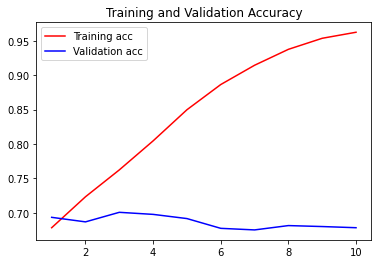

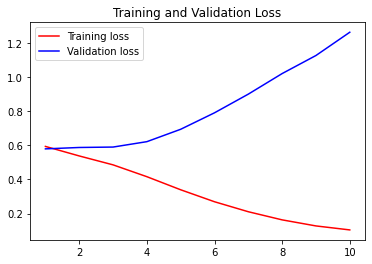

In [172]:
# plot loss rate and accuracy
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color = 'r', label = 'Training acc')
plt.plot(epochs, val_acc, color = 'b', label = 'Validation acc')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.figure()
plt.plot(epochs, loss, color = 'r', label = 'Training loss')
plt.plot(epochs, val_loss, color = 'b', label = 'Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


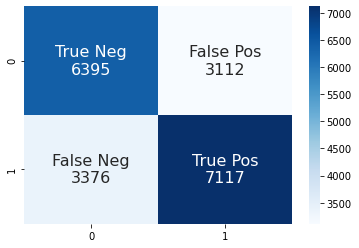

In [173]:
pred_test = model.predict(padded_test_doc)
rounded_pred_test = np.round(pred_test)
cf_matrix = confusion_matrix(y_test, rounded_pred_test)
meplot.cf_matrix_heatmap(cf_matrix)

In [174]:
print(classification_report(y_test,rounded_pred_test))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      9507
           1       0.70      0.68      0.69     10493

    accuracy                           0.68     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.68      0.68      0.68     20000



### Model Explainability

In [175]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer

def predict_for_lime(text_array):
    encoded =t.texts_to_sequences(text_array)
    text_data = pad_sequences(encoded, maxlen=max_length,padding='post')
    pred=model.predict(text_data)
    return pred

# test the predicition function
print ("Verify if predictions are correct for the function")
print(predict_for_lime([X_test[1],X_test[533]]))
print(y_test[1], y_test[533])
#initilaize Lime for text
explainer = LimeTextExplainer(class_names=["Positive"])

Verify if predictions are correct for the function
[[0.99998975]
 [0.65121645]]
1 0


In [176]:
#Check explanation for a negative review
exp = explainer.explain_instance(str(X_test[1]), predict_for_lime, num_features=10, top_labels=1)
exp.show_in_notebook()

In [177]:
#Check explanation for a negative review
exp = explainer.explain_instance(str(X_test[533]), predict_for_lime, num_features=10, top_labels=1)
exp.show_in_notebook()

- multivariate classification
- classification with hashtag
- topic modelling with hashtag
- topic modelling 
- word embedding with original text
- classification with pre-trained word embedding (DL)